<a href="https://colab.research.google.com/github/phps-28/Data-Science-PGEBM/blob/master/Mestrado/Projeto/Teste_3_Classifica%C3%A7%C3%A3o_de_Imagens_de_Embri%C3%B5es_V%C3%A1rios_Modelos_Pr%C3%A9_Treinados_17_11_23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Utilizando transferência de aprendizado com a rede de convolução já treinada

## **Importando as Libs**

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

## Subindo o arquivo zipado com as imagens

In [22]:
!unzip -q Base.zip
!ls

Base  Base.zip	sample_data


Agora temos uma pasta 'Base' que contém 8 subpastas. Cada subpasta contem arquivos de imagem de cada categoria.

In [23]:
!ls Base

AA  AB	AC  BA	BB  BC	CA  CB	CC


In [24]:
import os

# Testes com todas as categorias
num_skipped = 0
for folder_name in ("AA", "AB", "BA", "BB", "BC", "CA", "CB", "CC"): # descrevendo as pastas presentes dentro do arquivo main "Base"
    folder_path = os.path.join("Base", folder_name) # juntando o caminho de cada uma das pastas com o caminho da main pasta(Base)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname) # estabelecendo o caminho completo de cada imagem dentro da pasta main e subpastas
        try:
            fobj = open(fpath, "rb") # lendo e abrindo cada uma das imagens
            is_pfif = tf.compat.as_bytes("PFIF") in fobj.peek(10) # verificando a extensão correta das imagens '.png'
        finally:
            fobj.close()

print("Deletadas %d imagens" % num_skipped)

Deletadas 0 imagens


Distribuição entre as classe de imagens de embriões:

* AA - 133
* AB - 74
* AC - 1
* BA - 85
* BB - 153
* BC - 15
* CA - 3
* CB - 21
* CC - 1

In [49]:
# image_size = (180, 180)
image_size = (224, 224)
# image_size = (225, 225)
# image_size = (299, 299)
batch_size = 10

# train_ds: dataset de treinamento
# val_ds: dataset de validação (20%)

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "Base",
    validation_split=0.15,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 486 files belonging to 9 classes.
Using 414 files for training.
Using 72 files for validation.


## Visualizando as Imagens

In [26]:
# Exemplo de imagem da base
sample_image = tf.keras.preprocessing.image.load_img(r'/content/Base/AA/3AA.1.PNG', target_size = (224, 224))

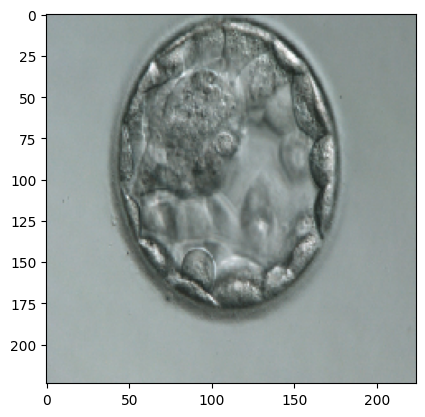

In [27]:
plt.imshow(sample_image);

In [28]:
type(sample_image)

PIL.Image.Image

In [29]:
sample_image = tf.keras.preprocessing.image.img_to_array(sample_image)

In [30]:
type(sample_image)

numpy.ndarray

In [31]:
np.shape(sample_image)

(224, 224, 3)

In [32]:
sample_image = np.expand_dims(sample_image, axis = 0)

In [33]:
sample_image.shape

(1, 224, 224, 3)

In [34]:
sample_image.max() # + próximo de branco

254.0

In [35]:
sample_image.min() # + próximo de preto

30.0

Fazendo a normalização dos pixels da imagem usando o pre processamento da rede pré treinada

In [36]:
sample_image = tf.keras.applications.resnet50.preprocess_input(sample_image)

In [37]:
sample_image.max() # + próximo de branco

150.061

In [38]:
sample_image.min() # + próximo de preto

-93.68

## Fazer a Tranferência de Aprendizado e Reuso do Modelo

In [39]:
# ResNet50
base_model =  tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)

In [ ]:
base_model.summary()

Agora será criada a rede neural Densa, que será personalizada, para juntá-la com essas camadas de convolução e pooling da ResNet 50

In [41]:
x = base_model.output

In [42]:
# Será feito a diminuição da dimensão desta última camada de saída da rede ResNet50 fazedno um pooling com a média dos valores da matriz dos pixels
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [43]:
# Criando as camadas Densas personalizadas
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
preds = tf.keras.layers.Dense(9, activation='softmax')(x)

In [44]:
# Criando um modelo que seja a união do modelo pré treinado + as camadas densas personalizadas
model = tf.keras.models.Model(inputs = base_model.input, outputs = preds)

In [ ]:
model.summary()

In [ ]:
for i, layer in enumerate(model.layers):
  print(i, layer.name)

In [47]:
# Como as camadas até a 175 são do modelo que já foi treinado, até a 175 não precisa ser treinada novamente
for layer in model.layers[:175]:
  layer.trainable = False

In [48]:
# serão treinadas as cmadas da 175 em diante, que são as camadas densas personalizadas
for layer in model.layers[175:]:
  layer.trainable = True

In [21]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

In [56]:
train_generator = train_datagen.flow_from_directory('/content/Base',
                                                    target_size = image_size,
                                                    color_mode = 'rgb',
                                                    batch_size = batch_size,
                                                    class_mode = 'categorical',
                                                    shuffle = True)

Found 486 images belonging to 9 classes.


In [57]:
# ResNet50
# # SGD(learning_rate=5e-5)
# model.compile(optimizer=keras.optimizers.SGD(learning_rate=5e-5) , loss='categorical_crossentropy', metrics=['accuracy'])

# ResNet50
# Adam(learning_rate=5e-5)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-5) , loss='categorical_crossentropy', metrics=['accuracy'])


MODELO 1
<br>
`ResNet50`
<br>
Optimizer `SGD(learning_rate=5e-5)`
<br>
Modelo treinado -> acurária = 0.5062 / loss = 1.3665
<br>
MODELO DESCONSIDERADO
<br>  
<br>
MODELO 2
<br>
`ResNet50`
<br>
Optimizer `Adam(learning_rate=5e-5)`
<br>
Modelo treinado -> acurária = 1.0000 / loss = 7.8470e-05
<br>
MODELO CONSIDERADO  

In [58]:
history = model.fit_generator(generator=train_generator,
                              epochs = 100)

Epoch 1/100


<ipython-input-58-38d536ec36c2>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


49/49 [==============================] - 9s 79ms/step - loss: 1.4388 - accuracy: 0.4712
Epoch 2/100
49/49 [==============================] - 4s 88ms/step - loss: 1.3059 - accuracy: 0.5123
Epoch 3/100
49/49 [==============================] - 4s 85ms/step - loss: 1.2099 - accuracy: 0.5741
Epoch 4/100
49/49 [==============================] - 4s 87ms/step - loss: 1.0830 - accuracy: 0.6049
Epoch 5/100
49/49 [==============================] - 4s 83ms/step - loss: 0.9663 - accuracy: 0.6646
Epoch 6/100
49/49 [==============================] - 4s 82ms/step - loss: 0.8676 - accuracy: 0.6790
Epoch 7/100
49/49 [==============================] - 4s 82ms/step - loss: 0.8354 - accuracy: 0.6996
Epoch 8/100
49/49 [==============================] - 4s 85ms/step - loss: 0.7559 - accuracy: 0.7263
Epoch 9/100
49/49 [==============================] - 4s 81ms/step - loss: 0.5800 - accuracy: 0.8230
Epoch 10/100
49/49 [==============================] - 4s 80ms/step - loss: 0.5086 - accuracy: 0.8560
Epoch 11/10

## Avaliando o Modelo

In [59]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

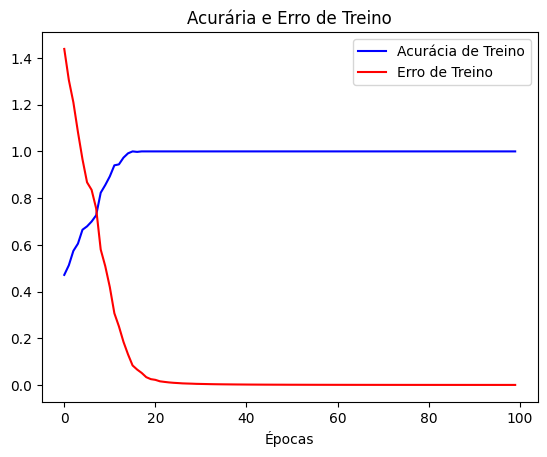

In [60]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure()
plt.plot(acc, 'b', label='Acurácia de Treino')
plt.plot(loss, 'r', label='Erro de Treino')
plt.xlabel('Épocas')
plt.title('Acurária e Erro de Treino')
plt.legend()
plt.savefig("Desempenho Modelo 2 ResNet50 9 Classes 224x224.pdf"); # salvar a figura em pdf

plt.show()

## Salvando e Carregando o Modelo

In [61]:
# Salvando o Modelo
model_json = model.to_json()
with open('model_ResNet50_Adam(5e-5).json','w') as json_file:
  json_file.write(model_json)

In [62]:
from keras.models import save_model
model_saved = save_model(model, '/content/weights_ResNet50_Adam(5e-5).hdf5')

<ipython-input-62-170562fee66f>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  model_saved = save_model(model, '/content/weights_ResNet50_Adam(5e-5).hdf5')


In [63]:
# Carregando a Rede Neural
with open('model_ResNet50_Adam(5e-5).json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "model_1", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, null, null, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_2"}, "registered_name": null, "name": "input_2", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": false, "dtype": "float32", "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "registered_name": null, "build_config": {"input_shape": [null, null, null, 3]}, "name": "conv1_pad", "inbound_nodes": [[["input_2", 0, 0, {}]]]}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv1_conv", "trainable": false, "dtype": "float32", "filters": 64, "kernel_size": [7, 7], "strides": [2, 2], "padding": "valid", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": true, "kernel_

In [64]:
model_loaded = tf.keras.models.model_from_json(json_saved_model)
model_loaded.load_weights('weights_ResNet50_Adam(5e-5).hdf5')
model_loaded.compile(loss = 'categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=5e-5), metrics=['accuracy'])

In [ ]:
model_loaded.summary()

In [ ]:
# keras.utils.plot_model(model_loaded, to_file = 'ResNet50.pdf' ,show_shapes=True)

## Testando o novo Modelo

1/1 [==============================] - 0s 24ms/step
Imagem 4AA 1 500.PNG
 100.00% AA
 0.00% AB
 0.00% AC
 0.00% BA
 0.00% BB
 0.00% BC
 0.00% CA
 0.00% CB
 0.00% CC.


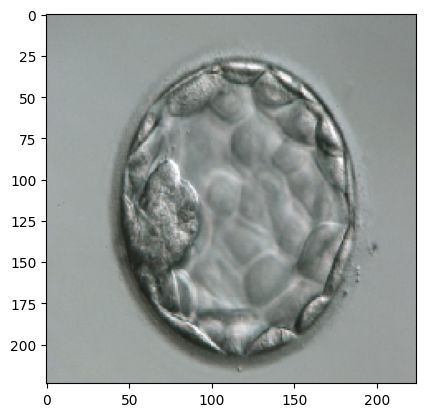

In [67]:
image_test_1 = tf.keras.preprocessing.image.load_img(r'/content/4AA 1 500.PNG', target_size=(224,224))
plt.imshow(image_test_1);

image_test_1 = tf.keras.preprocessing.image.img_to_array(image_test_1)
image_test_1 = np.expand_dims(image_test_1, axis = 0)
image_test_1 = tf.keras.applications.resnet50.preprocess_input(image_test_1)

predictions1 = model_loaded.predict(image_test_1)

# AA  AB	AC  BA	BB  BC	CA  CB	CC

score_AA = float(predictions1[0][0])
score_AB = float(predictions1[0][1])
score_AC = float(predictions1[0][2])
score_BA = float(predictions1[0][3])
score_BB = float(predictions1[0][4])
score_BC = float(predictions1[0][5])
score_CA = float(predictions1[0][6])
score_CB = float(predictions1[0][7])
score_CC = float(predictions1[0][8])

print("Imagem 4AA 1 500.PNG")
print(f" {100 * score_AA:.2f}% AA\n {100 * score_AB:.2f}% AB\n {100 * score_AC:.2f}% AC\n {100 * score_BA:.2f}% BA\n {100 * score_BB:.2f}% BB\n {100 * score_BC:.2f}% BC\n {100 * score_CA:.2f}% CA\n {100 * score_CB:.2f}% CB\n {100 * score_CC:.2f}% CC.")

In [ ]:
predictions1[0]

array([5.5825247e-05, 6.6711575e-01, 2.7004015e-03, 3.2003877e-01,
       1.0010095e-02, 2.6606763e-06, 7.6497592e-05, 3.1897696e-09],
      dtype=float32)